In [ ]:
%pip install -r requirements.txt

In [29]:
import os
import time
import pandas as pd
import shutil
from neo4j import GraphDatabase
from neo4j.exceptions import ServiceUnavailable
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
actions_df = pd.read_csv(
    "data/act-mooc/mooc_actions.tsv",
    sep="\t",
    header=None,
    names=["user_id", "target_id", "action_id", "timestamp"],
    dtype=str,
    low_memory=False
)

features_df = pd.read_csv(
    "data/act-mooc/mooc_action_features.tsv",
    sep="\t",
    header=None,
    names=["feature1", "feature2", "feature3", "feature4"],
    dtype=str,
    low_memory=False
)

labels_df = pd.read_csv(
    "data/act-mooc/mooc_action_labels.tsv",
    sep="\t",
    header=None,
    names=["label"],
    dtype=str,
    low_memory=False
)

# Reset the index to ensure alignment
actions_df.reset_index(drop=True, inplace=True)
features_df.reset_index(drop=True, inplace=True)
labels_df.reset_index(drop=True, inplace=True)

# Combine dataframes
combined_df = pd.concat([actions_df, features_df, labels_df], axis=1)

In [6]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411750 entries, 0 to 411749
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    411750 non-null  object
 1   target_id  411750 non-null  object
 2   action_id  411750 non-null  object
 3   timestamp  411750 non-null  object
 4   feature1   411750 non-null  object
 5   feature2   411750 non-null  object
 6   feature3   411750 non-null  object
 7   feature4   411750 non-null  object
 8   label      411750 non-null  object
dtypes: object(9)
memory usage: 28.3+ MB


In [ ]:
os.makedirs("data/processed", exist_ok=True)
# Step 1: Extract and Save Unique Users
users_df = combined_df[['user_id']].drop_duplicates()
users_df.to_csv("data/processed/users.csv", index=False)

# Step 2: Extract and Save Unique Targets
targets_df = combined_df[['target_id']].drop_duplicates()
targets_df.to_csv("data/processed/targets.csv", index=False)

# Step 3: Save Full Actions Table
combined_df.to_csv("data/processed/actions.csv", index=False)

- Use your own local paths

In [35]:
# Move files to Neo4j
neo4j_path = "C:\\Users\\mitsa\\.Neo4jDesktop\\relate-data\\dbmss\\dbms-732933c2-cb3e-428b-8547-fadf10cc4784\\import\\"
_=shutil.copy("data/processed/users.csv", f"{neo4j_path}users.csv")
_=shutil.copy("data/processed/targets.csv", f"{neo4j_path}targets.csv")

def split_actions_csv_and_copy(input_path, output_dir, neo4j_import_dir, chunk_size=20000):
    os.makedirs(output_dir, exist_ok=True)
    df = pd.read_csv(input_path, low_memory=False)
    global part_count
    part_count=0
    for i in range(0, len(df), chunk_size):
        chunk = df.iloc[i:i + chunk_size]
        filename = f"actions_part_{i//chunk_size + 1}.csv"
        local_path = os.path.join(output_dir, filename)
        chunk.to_csv(local_path, index=False)

        # Copy to Neo4j import directory
        neo4j_path = os.path.join(neo4j_import_dir, filename)
        shutil.copy(local_path, neo4j_path)
        print(f"✅ Saved and copied: {filename}")
        part_count+=1

split_actions_csv_and_copy(
    input_path="data/processed/actions.csv",
    output_dir="data/processed/splits",
    neo4j_import_dir="C:\\Users\\mitsa\\.Neo4jDesktop\\relate-data\\dbmss\\dbms-732933c2-cb3e-428b-8547-fadf10cc4784\\import\\",
    chunk_size=10000 # 5000 10000 20000
)

✅ Saved and copied: actions_part_1.csv
✅ Saved and copied: actions_part_2.csv
✅ Saved and copied: actions_part_3.csv
✅ Saved and copied: actions_part_4.csv
✅ Saved and copied: actions_part_5.csv
✅ Saved and copied: actions_part_6.csv
✅ Saved and copied: actions_part_7.csv
✅ Saved and copied: actions_part_8.csv
✅ Saved and copied: actions_part_9.csv
✅ Saved and copied: actions_part_10.csv
✅ Saved and copied: actions_part_11.csv
✅ Saved and copied: actions_part_12.csv
✅ Saved and copied: actions_part_13.csv
✅ Saved and copied: actions_part_14.csv
✅ Saved and copied: actions_part_15.csv
✅ Saved and copied: actions_part_16.csv
✅ Saved and copied: actions_part_17.csv
✅ Saved and copied: actions_part_18.csv
✅ Saved and copied: actions_part_19.csv
✅ Saved and copied: actions_part_20.csv
✅ Saved and copied: actions_part_21.csv
✅ Saved and copied: actions_part_22.csv
✅ Saved and copied: actions_part_23.csv
✅ Saved and copied: actions_part_24.csv
✅ Saved and copied: actions_part_25.csv
✅ Saved a

Downloaded Neo4jDesktop - 1.6.1 and created a Local Database

![Screenshot from the created Database in Neo4j Desktop](Neo4j_Desktop_Screenshot.png)

In [36]:
def check_database_status(driver):
    with driver.session(database="neo4j") as session:
        result = session.run("RETURN 'Neo4j is ready' AS status")
        print(result.single()["status"])
        
        # Count nodes
        result_nodes = session.run("MATCH (n) RETURN count(n) AS total_nodes")
        total_nodes = result_nodes.single()["total_nodes"]

        # Count relationships
        result_rels = session.run("MATCH ()-[r]->() RETURN count(r) AS total_rels")
        total_rels = result_rels.single()["total_rels"]

    print(f"📦 Total Nodes: {total_nodes}")
    print(f"🔗 Total Relationships: {total_rels}")

In [ ]:
def connect_to_neo4j(driver=None):
    if driver:
        driver.close()
    try:
        driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "2024-2025"))
        check_database_status(driver)
        return driver
    except ServiceUnavailable:
        print("❌ Could not connect to Neo4j. Is it running in Desktop? Please start it.")
        return None

driver = connect_to_neo4j()

Neo4j is ready
📦 Total Nodes: 418798
🔗 Total Relationships: 410000


❕Before running the cell below make sure that:
You have moved `users.csv`, `targets.csv`, and `actions.csv` into Neo4j Desktop's import folder:

- In Neo4j Desktop → Projects → Right-click your DB → "Open Folder" → "Import"

- Copy/paste the 3 CSVs there

- Make sure the DB has started

In [ ]:
def reset_database(driver):
    verify = input("Do you want to drop and recreate the 'neo4j' database? (y/n): ")
    if verify.lower() == "y":
        with driver.session(database="system") as session:
            # Drop and recreate the 'neo4j' database
            session.run("DROP DATABASE neo4j IF EXISTS")
            session.run("CREATE DATABASE neo4j")
            print("🧨 neo4j database has been dropped and recreated.")
            print("⏳ Waiting for Neo4j database to fully initialize...")
            time.sleep(30) # Wait for Neo4j to initialize the new database
            new_driver = connect_to_neo4j(driver) # Reconnect to the database
            return new_driver
        
driver = reset_database(driver) 

🧨 neo4j database has been dropped and recreated.
⏳ Waiting for Neo4j database to fully initialize...
Neo4j is ready
📦 Total Nodes: 0
🔗 Total Relationships: 0


- **OR** Run this in Neo4j Desktop Browser

```cypher
:use system
DROP DATABASE neo4j IF EXISTS;
CREATE DATABASE neo4j;
```
- Wait 10 - 15 seconds and then run this:

```cypher
:use neo4j
```


- Testing that DB is Up and Running and Connectable

In [37]:
with driver.session(database="neo4j") as session:
    result = session.run("RETURN 1 AS test")
    print(result.single())

<Record test=1>


In [85]:
def load_actions_in_parts(driver, filenames, folder="file:///"):
    for filename in filenames:
        print(f"📥 Loading {filename}")
        query = f"""
        CALL () {{
            LOAD CSV WITH HEADERS FROM '{folder}{filename}' AS row
            MATCH (u:User {{id: row.user_id}})
            MATCH (t:Target {{id: row.target_id}})
            CREATE (u)-[:PERFORMS {{
                action_id: row.action_id,
                timestamp: row.timestamp,
                feature1: toFloat(row.feature1),
                feature2: toFloat(row.feature2),
                feature3: toFloat(row.feature3),
                feature4: toFloat(row.feature4),
                label: toInteger(row.label)
            }}]->(t)
        }} IN TRANSACTIONS OF 1000 ROWS
        """
        with driver.session(database="neo4j") as session:
            session.run(query)
        print(f"✅ Loaded: {filename}")

def load_csv_data(driver):
    with driver.session(database="neo4j") as session:
        # Create indexes
        session.run("CREATE INDEX user_id_index IF NOT EXISTS FOR (u:User) ON (u.id)")
        session.run("CREATE INDEX target_id_index IF NOT EXISTS FOR (t:Target) ON (t.id)")
        print("🔧 Indexes created: user_id_index, target_id_index")

        # 1. Load Users
        session.run("""
        CALL () {
            LOAD CSV WITH HEADERS FROM 'file:///users.csv' AS row
            MERGE (:User {id: row.user_id})
        } IN TRANSACTIONS OF 100 ROWS
        """)
        print("✅ Loaded users.csv into User nodes")

        # 2. Load Targets
        session.run("""
        CALL () {
            LOAD CSV WITH HEADERS FROM 'file:///targets.csv' AS row
            MERGE (:Target {id: row.target_id})
        } IN TRANSACTIONS OF 100 ROWS
        """)
        print("✅ Loaded targets.csv into Target nodes")
        
        # 3. Load Actions
        files = [f"actions_part_{i}.csv" for i in range(1, part_count)]
        load_actions_in_parts(driver, files)
        print("✅ Loaded all actions_part_*.csv files into PERFORMS relationships")

def safe_load(driver):
    try:
        load_csv_data(driver)
        print(f"💯 Successfully loaded everything!")
    except ServiceUnavailable as e:
        print("🔌 Connection was dropped. Try restarting Neo4j and reconnecting the driver.")
        print("❌ Error:\n", e)

safe_load(driver)

🔧 Indexes created: user_id_index, target_id_index
✅ Loaded users.csv into User nodes
✅ Loaded targets.csv into Target nodes
📥 Loading actions_part_1.csv
✅ Loaded: actions_part_1.csv
📥 Loading actions_part_2.csv
✅ Loaded: actions_part_2.csv
📥 Loading actions_part_3.csv
✅ Loaded: actions_part_3.csv
📥 Loading actions_part_4.csv
✅ Loaded: actions_part_4.csv
📥 Loading actions_part_5.csv
✅ Loaded: actions_part_5.csv
📥 Loading actions_part_6.csv
✅ Loaded: actions_part_6.csv
📥 Loading actions_part_7.csv
✅ Loaded: actions_part_7.csv
📥 Loading actions_part_8.csv
✅ Loaded: actions_part_8.csv
📥 Loading actions_part_9.csv
✅ Loaded: actions_part_9.csv
📥 Loading actions_part_10.csv
✅ Loaded: actions_part_10.csv
📥 Loading actions_part_11.csv
✅ Loaded: actions_part_11.csv
📥 Loading actions_part_12.csv
✅ Loaded: actions_part_12.csv
📥 Loading actions_part_13.csv
✅ Loaded: actions_part_13.csv
📥 Loading actions_part_14.csv
✅ Loaded: actions_part_14.csv
📥 Loading actions_part_15.csv
✅ Loaded: actions_part_1

In [87]:
check_database_status(driver)

Neo4j is ready
📦 Total Nodes: 418798
🔗 Total Relationships: 410000


### CYPHER QUERIES EXECUTION

In [40]:
def load_queries_from_file(filepath):
    queries = []
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')

    current_description = None
    current_query_lines = []

    for line in lines:
        line = line.strip()
        if not line:
            continue
        if line.startswith("#"):  # it's a description
            if current_query_lines:
                queries.append((current_description, "\n".join(current_query_lines)))
                current_query_lines = []
            current_description = line[1:].strip()
        else:
            current_query_lines.append(line)

    if current_query_lines:
        queries.append((current_description, "\n".join(current_query_lines)))

    return queries

In [41]:
def save_query_to_csv(driver, query, output_path, display_output=True, benchmark=True):
    with driver.session(database="neo4j") as session:
        # Start timing
        if benchmark:
            t0 = time.perf_counter()
        result = session.run(query)
        # End timing
        if benchmark:
            t1 = time.perf_counter()
        data = [r.data() for r in result]
        df = pd.DataFrame(data)
        df.to_csv(output_path, index=False)
        print(f"✅ Saved: {output_path}")
        # Print timing result
        if benchmark:
            print(f"⏱️ Query executed in {t1 - t0:.4f} seconds.")
        # Display output (show up to max_rows rows)
        if display_output:
            print("\n--- Output ---")
            if not df.empty:
                display(df)
            else:
                print("No results returned.")
    return df  # Optionally, for further processing

In [42]:
def run_queries_from_file(driver, file_path, save_folder=None):
    os.makedirs(save_folder or "query_outputs", exist_ok=True)
    queries = load_queries_from_file(file_path)

    for i, (desc, cypher) in enumerate(queries):
        print(f"\n🔹 {desc}")
        save_path = os.path.join(save_folder or "query_outputs", f"query_{i+1:02d}_{desc.replace(' ', '_')}.csv")
        try:
            save_query_to_csv(driver, cypher, save_path)
        except Exception as e:
            print(f"❌ Failed to execute query {i+1}: {e}")

In [43]:
run_queries_from_file(driver, "cypher_queries.txt", save_folder="results")


🔹 Show a small portion of the graph
✅ Saved: results\query_01_Show_a_small_portion_of_the_graph.csv
⏱️ Query executed in 0.0203 seconds.

--- Output ---


,user,action,target
0,ACTIONID,TARGETID,USERID
1,0,0,0
2,1,1,0
3,2,2,0
4,3,1,0
5,4,2,0
6,5,3,0
7,6,4,0
8,7,5,0
9,8,6,0



🔹 Count all users
✅ Saved: results\query_02_Count_all_users.csv
⏱️ Query executed in 0.0070 seconds.

--- Output ---


,user_count
0,411750



🔹 Count all targets
✅ Saved: results\query_03_Count_all_targets.csv
⏱️ Query executed in 0.0077 seconds.

--- Output ---


,target_count
0,7048



🔹 Count all actions
✅ Saved: results\query_04_Count_all_actions.csv
⏱️ Query executed in 0.0110 seconds.

--- Output ---


,action_count
0,410000



🔹 Actions and targets of a specific user
✅ Saved: results\query_05_Actions_and_targets_of_a_specific_user.csv
⏱️ Query executed in 0.0180 seconds.

--- Output ---


,action_id,target_id
0,13,214



🔹 Count actions per user
✅ Saved: results\query_06_Count_actions_per_user.csv
⏱️ Query executed in 0.0091 seconds.

--- Output ---


,user_id,action_count
0,ACTIONID,1
1,0,1
2,1,1
3,2,1
4,3,1
...,...,...
409995,409994,1
409996,409995,1
409997,409996,1
409998,409997,1



🔹 Count users per target
✅ Saved: results\query_07_Count_users_per_target.csv
⏱️ Query executed in 0.5370 seconds.

--- Output ---


,target_id,user_count
0,USERID,1
1,0,76
2,1,26
3,2,189
4,3,6
...,...,...
7038,7037,6
7039,7038,8
7040,7039,6
7041,7040,12



🔹 Average actions per user
✅ Saved: results\query_08_Average_actions_per_user.csv
⏱️ Query executed in 0.0087 seconds.

--- Output ---


,avg_actions_per_user
0,1.0



🔹 Users and targets with positive Feature2
✅ Saved: results\query_09_Users_and_targets_with_positive_Feature2.csv
⏱️ Query executed in 0.0119 seconds.

--- Output ---


,user_id,target_id
0,4938,0
1,4940,0
2,4955,0
3,4957,0
4,4972,0
...,...,...
69775,404822,7035
69776,405118,7035
69777,405549,7035
69778,406319,7035



🔹 Count actions with label = 1 per target
✅ Saved: results\query_10_Count_actions_with_label_=_1_per_target.csv
⏱️ Query executed in 0.0055 seconds.

--- Output ---


,target_id,positive_label_count
0,3,1
1,4,1
2,8,1
3,9,1
4,10,1
...,...,...
4043,7034,1
4044,7035,1
4045,7037,1
4046,7038,1


In [33]:
def visualize_graph_sample(driver, limit=50):
    query = f"""
    MATCH (u:User)-[r:PERFORMS]->(t:Target)
    RETURN u.id AS user, t.id AS target
    LIMIT {limit}
    """
    with driver.session(database="neo4j") as session:
        result = session.run(query)
        edges = [(record["user"], record["target"]) for record in result]

    G = nx.DiGraph()
    G.add_edges_from(edges)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5, seed=2025)
    user_nodes = {u for u, _ in edges}
    target_nodes = {t for _, t in edges}
    color_map = ['skyblue' if node in user_nodes else 'lightgreen' for node in G.nodes()]
    nx.draw(G, pos, with_labels=True, node_size=300, arrows=True, node_color=color_map)
    plt.title("User ➝ Target PERFORMS Graph Sample")
    plt.savefig("results/graph_sample.png")
    plt.show()

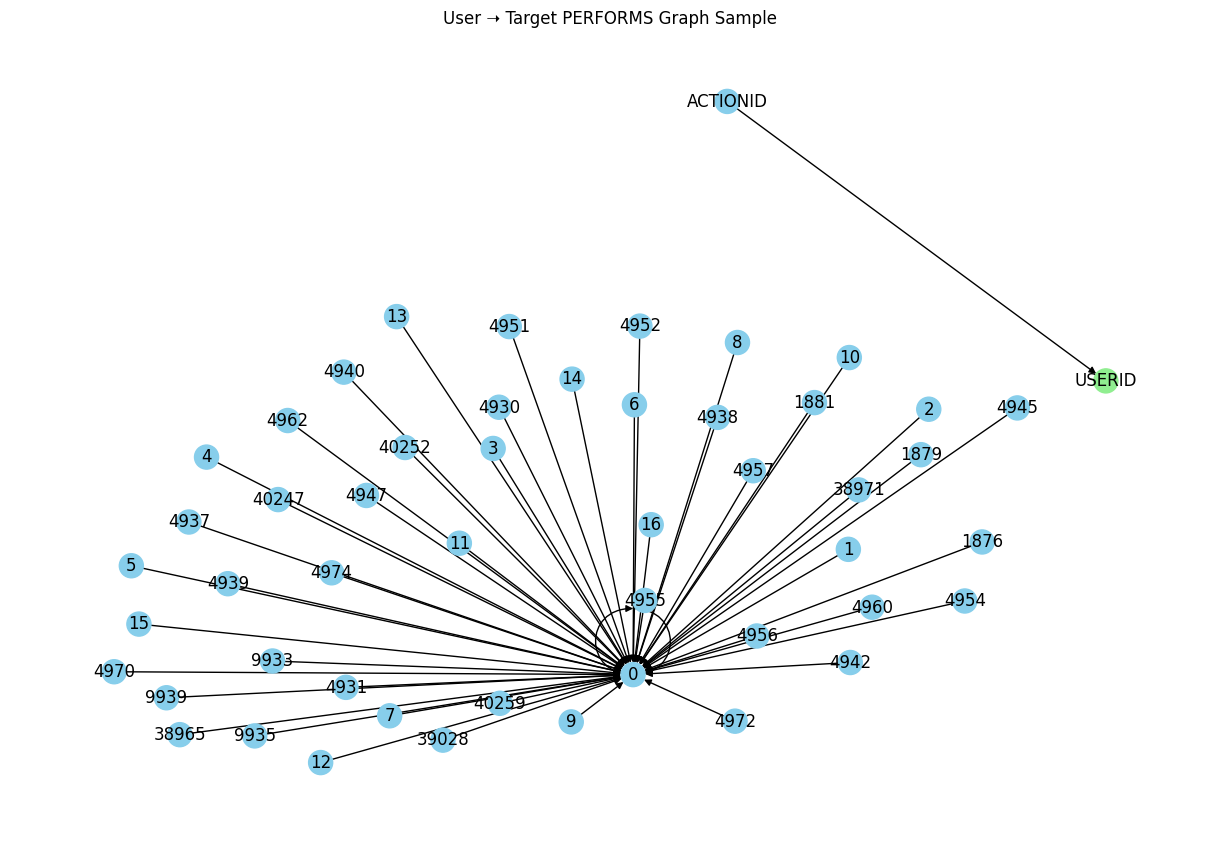

In [34]:
visualize_graph_sample(driver)